# Notebook 04 - Package Comparison

*Martin Vonk - 2023*

This notebooks compares the calculated drought indices to other (Python) packages or time series retrieved from other locations.
Current comparisons include: 
* standard_precip (Python)
* climate_indices (Python)
* pastas (Python)
* SPEI (R)

## Required packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
import scipy.stats as scs

import spei as si

print(si.show_versions())

Versions
python: 3.10.12
spei: 0.4.2
numpy: 1.26.4
scipy: 1.12.0
matplotlib: 3.8.3
pandas: 2.2.1



## Read Precipitation Data

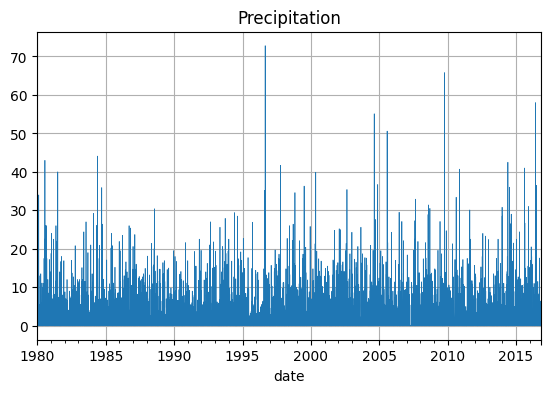

In [2]:
fileurl = "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data"
prec = (
    pd.read_csv(f"{fileurl}/rain_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
prec.plot(grid=True, linewidth=0.5, title="Precipitation", figsize=(6.5, 4));

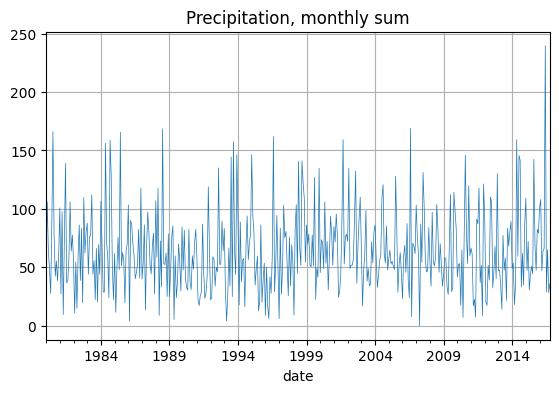

In [3]:
# get rolling sum
prec_rsum = prec.resample("ME").sum()
prec_rsum.plot(
    grid=True, linewidth=0.5, title="Precipitation, monthly sum", figsize=(6.5, 4)
);

## Compute Standardized Precipitation Index

### Using SPEI package

In [4]:
spi = si.spi(prec_rsum, dist=scs.gamma, prob_zero=True, timescale=3, fit_freq="ME")
spi  # pandas Series

date
1980-03-31    0.798607
1980-04-30    1.341499
1980-05-31   -0.429903
1980-06-30   -0.089408
1980-07-31    1.136106
                ...   
2016-06-30    2.535965
2016-07-31    1.829305
2016-08-31    0.736336
2016-09-30   -1.299582
2016-10-31   -1.315595
Freq: ME, Length: 440, dtype: float64

### Using standard_precip package

In [5]:
from standard_precip import spi as sp_spi

# standard_precip also needs rolling sum dataframe, even though you provide freq="M" and scale = 1
precdf = prec_rsum.to_frame().reset_index().copy()

# initialize spi
standardp_spi_inst = sp_spi.SPI()

# caclulate index with many parameters
standardp_spi = standardp_spi_inst.calculate(
    precdf,
    date_col="date",
    precip_cols="rain",
    freq="M",
    scale=3,  # note that scale is not the same for the standard deviation in SciPy
    fit_type="mle",
    dist_type="gam",
)
standardp_spi.index = standardp_spi.loc[
    :, "date"
].values  # create datetimeindex because date had to be a column

standardp_spi  # pandas DataFrame

,date,rain_scale_3,rain_scale_3_calculated_index
1980-01-31,1980-01-31,NaN,NaN
1980-02-29,1980-02-29,NaN,NaN
1980-03-31,1980-03-31,219.0,0.798607
1980-04-30,1980-04-30,217.8,1.341101
1980-05-31,1980-05-31,139.4,-0.434361
...,...,...,...
2016-06-30,2016-06-30,369.6,2.535965
2016-07-31,2016-07-31,334.7,1.829305
2016-08-31,2016-08-31,333.6,1.749250
2016-09-30,2016-09-30,122.4,-1.333315


### Using climate_indices package

I could not install it anymore.. But the code looks like this:

In [6]:
# from climate_indices.compute import scale_values, Periodicity
# from climate_indices import compute, indices, utils

In [7]:
# initial_year = prec_rsum.index[0].year
# calibration_year_initial = prec_rsum.index[0].year
# calibration_year_final = prec_rsum.index[-1].year
# period_times = 366
# scale = 1
# periodicity = compute.Periodicity.daily

# values = prec_rsum.values

# scaled_values = compute.scale_values(
#     values,
#     scale=scale,
#     periodicity=periodicity,
# )

# alphas, betas = compute.gamma_parameters(
#     scaled_values,
#     data_start_year=initial_year,
#     calibration_start_year=calibration_year_initial,
#     calibration_end_year=calibration_year_final,
#     periodicity=periodicity,
# )

# gamma_params = {"alpha": alphas, "beta": betas}

# spival = indices.spi(
#     values,
#     scale=scale,
#     distribution=indices.Distribution.gamma,
#     data_start_year=initial_year,
#     calibration_year_initial=calibration_year_initial,
#     calibration_year_final=calibration_year_final,
#     periodicity=compute.Periodicity.daily,
#     fitting_params=gamma_params,
# )

# climateind_spi = pd.Series(spival, index=prec_rsum.index, name="Climate Index SPI")
# climateind_spi

### Using SPEI R package

In [8]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()

sr = importr("SPEI")

spir_res = sr.spi(prec_rsum.values, scale=3)
r_spi = pd.Series(spir_res[2].ravel(), index=prec_rsum.index, name="SPI")
r_spi

[1] "Calculating the Standardized Precipitation Evapotranspiration Index (SPEI) at a time scale of 3. Using kernel type 'rectangular', with 0 shift. Fitting the data to a Gamma distribution. Using the ub-pwm parameter fitting method. Checking for missing values (`NA`): all the data must be complete. Using the whole time series as reference period. Input type is array. No time information provided, assuming a monthly time series."


date
1980-01-31         NaN
1980-02-29         NaN
1980-03-31    0.772307
1980-04-30    1.244421
1980-05-31   -0.357370
                ...   
2016-06-30    2.646909
2016-07-31    1.735676
2016-08-31    1.552881
2016-09-30   -1.315847
2016-10-31   -1.267677
Freq: ME, Name: SPI, Length: 442, dtype: float64

## Plot and compare

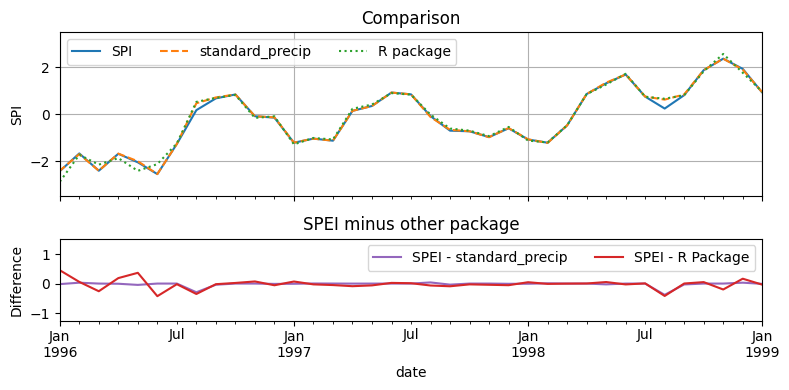

In [9]:
f, ax = plt.subplot_mosaic(
    [["SPI"], ["DIFF"]],
    figsize=(8, 4),
    sharex=True,
    height_ratios=[2, 1],
)
spi.plot(ax=ax["SPI"], grid=True, linestyle="-", label="SPI")
standardp_spi.iloc[:, -1].plot(
    ax=ax["SPI"],
    color="C1",
    grid=True,
    linestyle="--",
    label="standard_precip",
)
# climateind_spi.plot(
#     ax=ax["SPI"], color="C2", grid=True, linestyle=":", label="climate_indices"
# )
r_spi.plot(ax=ax["SPI"], color="C2", grid=True, linestyle=":", label="R package")

(ax["SPI"].set_ylim(-3.5, 3.5),)
(ax["SPI"].set_title("Comparison"),)
(ax["SPI"].set_ylabel("SPI"),)
ax["SPI"].legend(ncol=3)

(spi - standardp_spi.iloc[:, -1]).plot(
    ax=ax["DIFF"], color="C4", label="SPEI - standard_precip", grid=True
)
(spi - r_spi).plot(ax=ax["DIFF"], color="C3", label="SPEI - R Package")

# ax["DIFF1"].set_ylim(-0.05, 0.05)
ax["DIFF"].legend(ncol=2)
ax["DIFF"].set_title("SPEI minus other package")
ax["DIFF"].set_ylabel("Difference")
ax["DIFF"].set_xlim("1996", "1999")
f.tight_layout()

Difference is very small between SPEI an the standard_precip package. However there is a significant difference beteween the SPEI and climate_indices package, not sure why. Maybe it has to do with the fitting method used for the gamma distribution?

The standard_precip package does not explicitely support the Standardized Precipitation Evaporation Index, as far as I can see. However, the SPI class in standard_precip could probably be used, even though the naming of `precip_cols` is not universal. In general, the standard_precip package needs much more keyword arguments while the SPEI package makes more use of all the nice logic already available in SciPy and Pandas.

The climate_indices package needs even more code.

The SPEI R package also has a similar result but seems to vary a bit more. More research is needed to understand why that is the case. Most likely is the differences in fitting the gamma distribution.

# Compute Standardized Groundwater Index

In [10]:
head = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/B32C0639001.csv",
    index_col=0,
    parse_dates=True,
).squeeze()

sgi = si.sgi(head, fit_freq="ME")
sgi_pastas = ps.stats.sgi(head)

In [11]:
pd.concat([sgi, sgi_pastas], axis=1).rename(columns={0: "SGI", "head": "Pastas"})

,SGI,Pastas
date,,
1981-07-03,1.101146,1.101146
1981-07-17,0.776422,0.776422
1981-07-30,0.402250,0.402250
1981-08-19,0.102491,0.102491
1981-09-02,-0.282216,-0.282216
...,...,...
2005-07-14,-0.130927,-0.130927
2005-07-28,-0.346234,-0.346234
2005-08-29,-0.723476,-0.723476


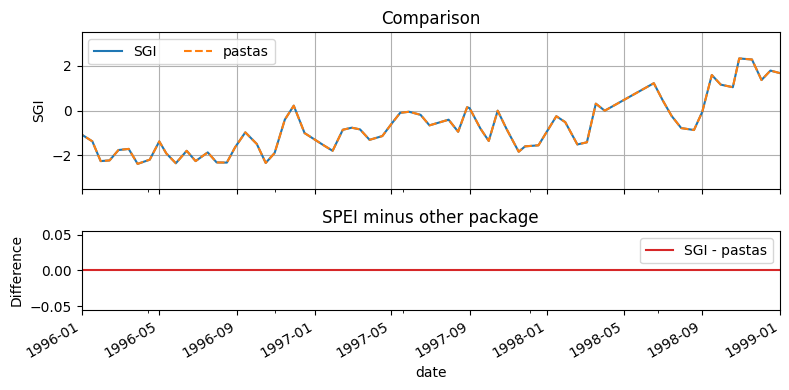

In [12]:
f, ax = plt.subplot_mosaic(
    [["SGI"], ["DIFF"]],
    figsize=(8, 4),
    sharex=True,
    height_ratios=[2, 1],
)
sgi.plot(ax=ax["SGI"], grid=True, linestyle="-", label="SGI")
sgi_pastas.plot(ax=ax["SGI"], color="C1", grid=True, linestyle="--", label="pastas")
(ax["SGI"].set_ylim(-3.5, 3.5),)
(ax["SGI"].set_title("Comparison"),)
(ax["SGI"].set_ylabel("SGI"),)
ax["SGI"].legend(ncol=3)

(sgi - sgi_pastas).plot(ax=ax["DIFF"], color="C3", label="SGI - pastas")

ax["DIFF"].legend(ncol=2)
ax["DIFF"].set_title("SPEI minus other package")
ax["DIFF"].set_ylabel("Difference")
ax["DIFF"].set_xlim("1996", "1999")
f.tight_layout()